In [143]:
%matplotlib inline

In [144]:
import os
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib as mpl
import seaborn as sns
from graph_tool import GraphView
from graph_tool.draw import sfdp_layout, graph_draw
from sklearn.metrics import average_precision_score
from collections import OrderedDict

from helpers import infected_nodes, cascade_source
from graph_helpers import load_graph_by_name, remove_filters, get_edge_weights, extract_edges, extract_nodes
from random_steiner_tree.util import from_gt
from viz_helpers import lattice_node_pos
from sample_pool import TreeSamplePool
from query_selection import PredictionErrorQueryGenerator, WeightedPredictionErrorQueryGenerator
from simulator import Simulator
from tree_stat import TreeBasedStatistics
from experiment import gen_input
from root_sampler import build_true_root_sampler
from inference import infection_probability

from viz_helpers import visualize, query_plot_setting, default_plot_setting, tree_plot_setting

In [145]:
graph = 'lattice-1024'
num_queries_to_show = 5
sampling_method = 'loop_erased'
obs_method = "leaves"
dataset_id = '{}-mic-s0.02-o{}'.format(graph, obs_method)
cascade_dir = 'cascade/{}'.format(dataset_id)
fig_dirname = 'figs/why-prederror-degenerates'

In [146]:
g = load_graph_by_name(graph, weighted=True)
g_rev = load_graph_by_name(graph, weighted=True, suffix="_reversed")
g_und = GraphView(g, directed=False)
g_und.set_directed(False)
if graph.startswith('lattice'):
    n = int(np.sqrt(g.num_vertices()))
    pos = lattice_node_pos(g, shape=(n, n))
else:
    pos = sfdp_layout(g)

load graph from data/lattice-1024/graph_weighted.gt
load graph from data/lattice-1024/graph_weighted_reversed.gt


In [147]:
if True:
    obs, c, tree = pkl.load(open('cascade-weighted/lattice-1024-mic-s0.02-o0.5/9.pkl', 'rb'))
else:
    if False:
        obs, c, tree = gen_input(g, source=18, p=get_edge_weights(g), model='ic', observation_method='leaves', 
                                 min_size=15, max_size=80, return_tree=True)
        pkl.dump((obs, c, tree), open('cascade-weighted/{}-example.pkl'.format(graph), 'wb'))    
    else:
        obs, c, tree = pkl.load(open('cascade-weighted/{}-example.pkl'.format(graph), 'rb'))
inf_nodes = infected_nodes(c)
hidden_infs = set(inf_nodes) - set(obs)
source = cascade_source(c)

In [148]:
from helpers import cascade_info
cascade_info(obs, c)

source: 47
|casdade|: 20
|observed nodes|: 10


In [194]:
gv = remove_filters(g_rev)  # the reserved graph

weights = get_edge_weights(gv)
gi = from_gt(gv, weights=weights)

sampler = TreeSamplePool(
    gv,
    n_samples=2500,
    method=sampling_method,
    gi=gi,
    return_type='nodes',
    with_resampling=False,
    with_inc_sampling=False)

params = {'n_node_samples': None,
          'prune_nodes': True,
          'root_sampler': 'true_root',
          'root_sampler_eps': 0.0,
          'min_proba': 0.01,
          'n_node_samples': None,
          'error_estimator': TreeBasedStatistics(gv)}


q_gen = PredictionErrorQueryGenerator(gv, sampler, **params, verbose=True)
sim = Simulator(gv, q_gen, gi=gi, print_log=True)

In [195]:
qs = sim.run(10, obs, c)
queries = qs[0]


  0%|          | 0/10 [00:00<?, ?it/s]

pruning candidates from 1014 to 734
no estimation node sampling



 10%|█         | 1/10 [00:09<01:28,  9.81s/it]

update samples started
update samples done
pruning candidates from 733 to 620
no estimation node sampling


update samples started



 20%|██        | 2/10 [00:18<01:14,  9.34s/it]

update samples done
pruning candidates from 619 to 464
no estimation node sampling



 30%|███       | 3/10 [00:22<00:55,  7.93s/it]

update samples started
update samples done
pruning candidates from 463 to 369
no estimation node sampling



 40%|████      | 4/10 [00:25<00:38,  6.48s/it]

update samples started
update samples done
pruning candidates from 368 to 285
no estimation node sampling


update samples started



 50%|█████     | 5/10 [00:27<00:25,  5.15s/it]

update samples done
pruning candidates from 284 to 283
no estimation node sampling



 60%|██████    | 6/10 [00:29<00:16,  4.24s/it]

update samples started
update samples done
pruning candidates from 282 to 267
no estimation node sampling



 70%|███████   | 7/10 [00:31<00:10,  3.53s/it]

update samples started
update samples done
pruning candidates from 266 to 248
no estimation node sampling


update samples started



 80%|████████  | 8/10 [00:33<00:05,  2.92s/it]

update samples done
pruning candidates from 247 to 240
no estimation node sampling



 90%|█████████ | 9/10 [00:34<00:02,  2.46s/it]

update samples started
update samples done
pruning candidates from 239 to 194
no estimation node sampling


num. queries reached


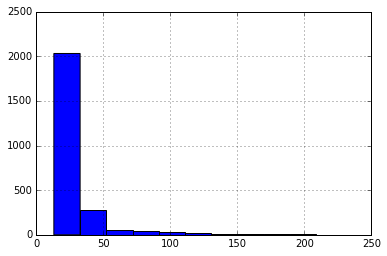


Exception in thread Thread-10:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.5/dist-packages/tqdm/_tqdm.py", line 102, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



In [196]:
pd.Series([len(t) for t in sampler.samples]).hist()

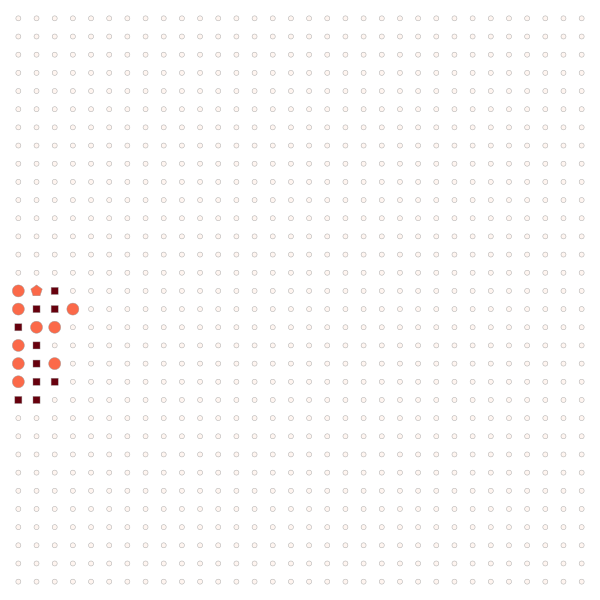

In [153]:
if tree is None:
    setting = default_plot_setting(g_und, c, obs)
else:
    setting = tree_plot_setting(g_und, c, obs, tuple(extract_edges(tree)))
visualize(g_und, pos, **setting, output='{}/cascade.png'.format(fig_dirname))

In [180]:
c[queries]

array([-1, -1, -1, -1, -1, -1, -1, -1,  5,  5], dtype=int32)

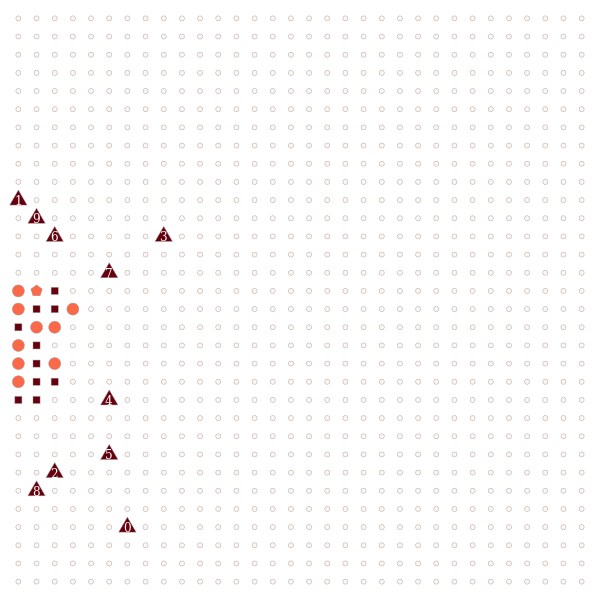

In [197]:
s = query_plot_setting(g, c, obs, queries, with_labels=True)
#s['node_size_info'][(49, )] = 20
visualize(g_und, pos, **s, output='{}/queries.png'.format(fig_dirname))

In [198]:
from viz_helpers import tree_plot_setting, visualize
from inference import infection_probability

In [199]:
sampler_before = TreeSamplePool(
    remove_filters(g_rev),
    n_samples=2500,
    method=sampling_method,
    gi=gi,
    return_type='nodes',
    with_resampling=False,
    with_inc_sampling=False)
sampler_before.fill(obs, root_sampler=build_true_root_sampler(c))

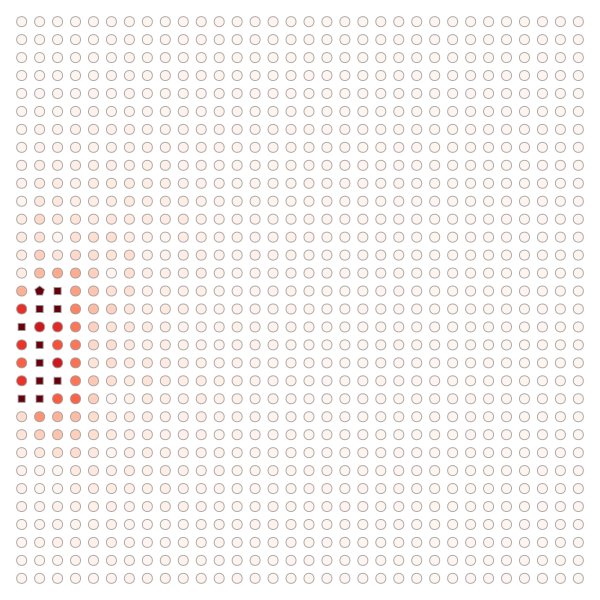

In [200]:
estimator = TreeBasedStatistics(g, sampler_before.samples)

probas_before = infection_probability(g, obs, sampler_before, estimator)
viz = InfectionProbabilityViz(g_und, pos)
# probas_before[obs] = 0
# probas_before[source] = 0
viz.plot(c, obs, probas_before, output='{}/inf-probas-before.png'.format(fig_dirname))

In [201]:
hidden_infs = list(set(infected_nodes(c)) - set(obs))
print("node before after")
for v, p1, p2 in zip(hidden_infs, probas_before[hidden_infs], probas_after[hidden_infs]):
    print(v, p1, p2)

node before after
15 0.2824 0.2452
112 0.422 0.0
16 0.6596 0.6228
18 0.6448 0.6988
83 0.7396 0.7736
19 0.5284 0.6368
20 0.6508 0.718
47 1.0 1.0
49 0.7432 0.8356
81 0.6788 1.0


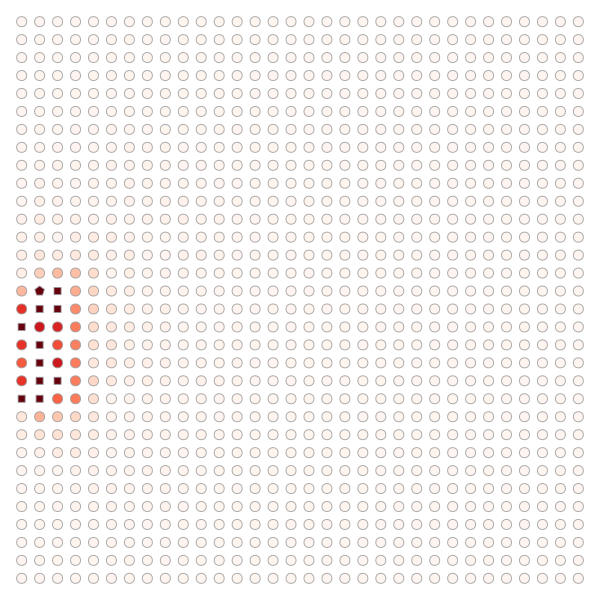

In [202]:
from viz_helpers import InfectionProbabilityViz

estimator = TreeBasedStatistics(g, sampler.samples)

probas_after = infection_probability(g, obs, sampler, estimator)

# probas_after[obs] = 0
# probas_after[source] = 0

viz = InfectionProbabilityViz(g_und, pos)
viz.plot(c, obs, probas_after, output='{}/inf-probas-after.png'.format(fig_dirname))


In [ ]:
from graph_helpers import extract_nodes_from_tuples

gv = remove_filters(g_rev)

weights = get_edge_weights(gv)
gi = from_gt(gv, weights=weights)

sampler = TreeSamplePool(
    gv,
    n_samples=250,
    method='cut',
    gi=gi,
    return_type='tuples',
    with_inc_sampling=False)
sampler.fill(obs,
             root_sampler=build_true_root_sampler(c))
sample_sizes =[len(s)-1 for i, s in enumerate(sampler.samples)]

pd.Series(sample_sizes).hist()

In [ ]:
sample_id_sizes =[(i, len(s)) for i, s in enumerate(sampler.samples)]
sorted(sample_id_sizes, key=lambda tpl: abs(tpl[1] - len(inf_nodes)), reverse=True)

In [ ]:
t = sampler.samples[240]
# source = tuple(np.logical_and(t.degree_property_map('out').a > 0, t.degree_property_map('in').a == 0).nonzero()[0])
print(source)
tree_nodes = tuple(extract_nodes_from_tuples(t))
tree_edges = tuple(t)

node_color_info = OrderedDict()
node_color_info[tree_nodes] = 0.5
node_color_info[tuple(obs)] = 1.0
node_color_info[(source, )] = 1.0
node_color_info['default'] = 0

node_shape_info = OrderedDict()
node_shape_info[tuple(obs)] = 'square'
node_shape_info['default'] = 'circle'
node_shape_info[(source, )] = 'pentagon'

node_size_info = {
    tuple(obs): 10,
    tree_nodes: 12.5,
    (source, ): 15,
    'default': 5
}
edge_color_info = {
    tree_edges: 'red',
    'default': 'white'
}
edge_pen_width_info = {
    'default': 2.0
}
visualize(g_und, pos,
          node_color_info,
          node_shape_info,
          node_size_info,
          edge_color_info,
          edge_pen_width_info,
          output='figs/why-prederror-fails/bad-tree.png')

In [ ]:
gv = remove_filters(g)

weights = get_edge_weights(gv)
gi = from_gt(gv, weights=weights)

sampler = TreeSamplePool(
    gv,
    n_samples=1,
    method='cut',
    gi=gi,
    return_tree_nodes=False,
    with_inc_sampling=False)
sampler.fill(obs,
             root_sampler=build_true_root_sampler(c))

t = sampler.samples[0]
list(t.vertex(source).out_edges())
print(t)

In [ ]:
from graph_tool.topology import random_spanning_tree
pred = random_spanning_tree(g, root=source)
spt = GraphView(g, efilt=pred)
list(spt.vertex(source).in_edges())

In [ ]:
# what are the pruned nodes
# what's the infection probability and score of the query node